In [1]:
import torch
import lightning as L 
import matplotlib.pyplot as plt
from torch import nn 
from pathlib import Path
import os 
import numpy as np
from dotenv import load_dotenv
from transphorm.model_components.data_objects import SyntheticFPDataModule
from transphorm.model_components.analyzers import FeatureExtractor
from transphorm.model_components.model_modules import BranchingCNNDecoder, BranchingCNNEncoder

In [2]:
%load_ext autoreload
%autoreload 2

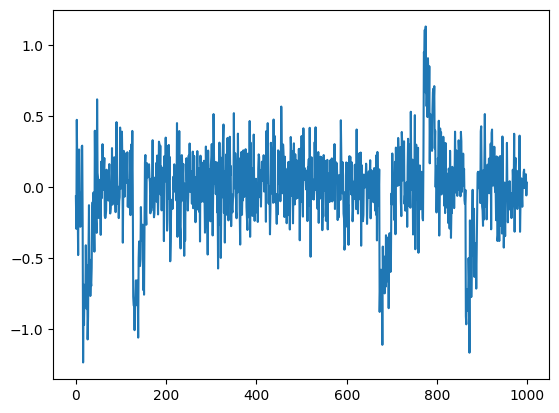

In [7]:
data_path = os.getenv("DATA_PATH")

data_mod = SyntheticFPDataModule(data_path)
data_mod.prepare_data()
data_mod.setup("test")
x = data_mod.train[0][0].view(1,3,-1)
plt.plot(x[0][0].detach().numpy())

In [14]:
class BranchingCNNEncoder(nn.Module):
    def __init__(self, input_channels =3, base_dim = 16):

        super().__init__()

        self.local_branch = nn.Sequential(
            nn.Conv1d(input_channels, base_dim, kernel_size=3, padding=1, dilation=1),
            nn.ReLU(),
            nn.Conv1d(base_dim, base_dim*2, kernel_size=3, padding=1, dilation=1),
            nn.ReLU()
        )

        self.mid_branch = nn.Sequential(
            nn.Conv1d(input_channels, base_dim, kernel_size=9, padding=1, dilation=8),
            nn.ReLU(),
            nn.Conv1d(base_dim, base_dim*2, kernel_size=9,padding = 1, dilation=8),
            nn.ReLU()
        )
        self.long_brach = nn.Sequential(
            nn.Conv1d(input_channels, base_dim, kernel_size=27, padding=1, dilation=16),
            nn.ReLU(),
            nn.Conv1d(base_dim, base_dim*2, kernel_size=27, padding= 1, dilation=16),
            nn.ReLU()
        )
        self.fusion = nn.Conv1d(base_dim*2,base_dim*4, kernel_size=3, stride = 1)
        self.self_attention = nn.MultiheadAttention(embed_dim=base_dim*4, num_heads=4)


    def forward(self, x):
        local_maps = self.local_branch(x)
        mid_maps = self.mid_branch(x)
        long_maps = self.long_brach(x)

        combined_maps = torch.cat([local_maps, mid_maps, long_maps], dim =2)

        fused = self.fusion(combined_maps)
        fused = fused.permute(2,0,1) # reorganize to seq len, batch, channels
        attend, _ = self.self_attention(fused, fused, fused)
        output = attend.permute(1,2,0)

        return output
    
class BranchingCNNDecoder(nn.Module):
    def __init__(self, output_channels = 3, base_dim = 16):
        super().__init__()

        self.self_attention = nn.MultiheadAttention(embed_dim=base_dim * 4, num_heads=4)
        self.inverse_fusion = nn.Conv1d(base_dim*4, base_dim*2, kernel_size=3, stride = 1)

        self.long_branch = nn.Sequential(
            nn.ConvTranspose1d(base_dim * 2, base_dim, kernel_size=27, padding=1, dilation = 16),
            nn.ReLU(), 
            nn.ConvTranspose1d(base_dim, output_channels, kernel_size=27, padding=1, dilation=16),
            nn.ReLU()
        )
        self.mid_branch = nn.Sequential(
            nn.ConvTranspose1d(base_dim*2, base_dim, kernel_size=9, padding = 1, dilation=8),
            nn.ReLU(),
            nn.ConvTranspose1d(base_dim, output_channels, kernel_size=9, padding = 1, dilation=8),
            nn.ReLU()
        )
        self.local_branch = nn.Sequential(
            nn.ConvTranspose1d(base_dim*2, base_dim, kernel_size=3, padding = 1, dilation=1),
            nn.ReLU(),
            nn.ConvTranspose1d(base_dim, output_channels, kernel_size=3, padding = 1, dilation=1),
            nn.ReLU()
        )
    def forward(self, x):
        # permute for attenion block - #(seq len, batch, channels)
        x = x.permute(2,0,1)
        x, _ = self.self_attention(x, x, x)

        # permute for  inverse fusion and cnn transpose
        # batch channels, seq leng
        x = x.permute(1,2,0)
        x = self.inverse_fusion(x)
        # splits omn sequence leng into 3 dim - recall this is extra long seq

        long_x, mid_x, local_x,_ = torch.split(x, x.size(2)//3, dim = 2)
        long_x = self.long_branch(long_x)
        mid_x = self.mid_branch(mid_x)
        local_x = self.local_branch(local_x)

        long_x = nn.functional.interpolate(long_x, size = 1000, mode = 'linear', align_corners=False)
        mid_x = nn.functional.interpolate(mid_x, size = 1000, mode = 'linear', align_corners=False)
        local_x = nn.functional.interpolate(local_x, size = 1000, mode = 'linear', align_corners=False)


        print(local_x.shape, mid_x.shape, long_x.shape )

        output = local_x+mid_x+long_x
        return output


encoder = BranchingCNNEncoder()
decoder = BranchingCNNDecoder()
encoder.eval()
out = encoder(x)
out = decoder(out)



torch.Size([1, 3, 1000]) torch.Size([1, 3, 1000]) torch.Size([1, 3, 1000])


torch.Size([1, 32, 1000])